In [1]:
import numpy as np
from matplotlib import pyplot as plt
 
import pandas as pd

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler ,MinMaxScaler

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.preprocessing import MinMaxScaler
 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подгружаем данные

In [3]:
data = pd.read_csv('/content/drive/MyDrive/данные с акселерометра/dataset_w8_o25.csv', delimiter = ';')

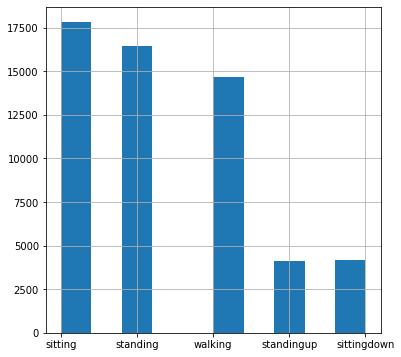

In [10]:
 data['class'].hist(figsize= (6,6),grid= True ,)

Фуекия , которая подбирает гиперпараметры модели решетчатым поиском на кросс-вадидации. Возвращает лучшую модель , лушую оценку и параметры.

In [ ]:
def fit_and_choose(X,Y , model ,  grid_par , score_mes , spliter_cvd , verbs ,n_proc ):
  gsC =GridSearchCV(estimator= model,
             param_grid=   grid_par,
             scoring =score_mes,
             refit=True,
             cv = spliter_cvd ,
             verbose =  verbs,
             n_jobs = n_proc
             )
  gsC.fit(X, Y)
  return {'best model': gsC.best_estimator_ ,
          'best params' : gsC.best_params_,
          'best score': gsC.best_score_}
   

Функция считает f1 меру с микро усреднением и выводит матрицу ошибок.

In [ ]:
def conf_matr_and_score_f1(Y_predicted , Y_true,le):

  cmatr  = confusion_matrix(le.inverse_transform(Y_true),le.inverse_transform(Y_predicted) , labels=['sitting', 'sittingdown', 'standing', 'standingup', 'walking'])
  score_f1 = f1_score(Y_true,Y_predicted  , average='micro')
  cmatr_df = pd.DataFrame(cmatr,columns=['sitting', 'sittingdown', 'standing', 'standingup', 'walking'], index=['sitting', 'sittingdown', 'standing', 'standingup', 'walking'])
  return {'conf_matr': cmatr_df , 'f1-score':score_f1 }

Функция делит выборку на 3 части  - тренировочная, валидационная и тестовая.

In [ ]:
def train_val_test_split(X,Y, rand_state):
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.4, random_state=rand_state  ,stratify = Y )
  X_val, X_test, Y_val, Y_test = train_test_split(X_val,  Y_val, test_size=0.5, random_state=rand_state ,stratify =  Y_val )
    
  return X_train, X_val,X_test,Y_train, Y_val, Y_test

Функция выполняет стандартизацию или нормализацию трёх выборок.


In [ ]:
def scale_x(X1,X2,X3, type_of_scale = None):
  if type_of_scale == 'minmax':
    scaler = MinMaxScaler()
  else: scaler = StandardScaler()
  scaler = scaler.fit(X1)
  X1  = scaler.transform( X1 )
  X2 =  scaler.transform( X2 )
  X3 =  scaler.transform( X3 )
  return X1, X2, X3

Нужно подобрать модель, которая будет выдавать максимальный результат на тестовой выборке. Промежуточное тестирование с оптимизацией гиперпараметров делается на валидационной выборке.

Работаем на  пространстве признаков - 12

'x1_mean', 'y1_mean', 'z1_mean', 'x2_mean', 'y2_mean', 'z2_mean', 'x3_mean','y3_mean', 'z3_mean', 'x4_mean', 'y4_mean', 'z4_mean'

Закодируем метки классов и разделим выборку

In [ ]:
le =  LabelEncoder()
le.fit(data['class'])
Y = le.transform(data['class'])
 # preparing X data and split
X =np.array( data[['x1_mean', 'y1_mean', 'z1_mean', 'x2_mean', 'y2_mean', 'z2_mean', 'x3_mean', 'y3_mean', 'z3_mean', 'x4_mean', 'y4_mean', 'z4_mean']]) 
X_train, X_val, X_test,  Y_train, Y_val,Y_test = train_val_test_split(X, Y, rand_state=42 )
# standart scale X train and test 
X_train_std , X_val_std , X_test_std = scale_x(X_train, X_val, X_test)

In [ ]:
le.classes_

array(['sitting', 'sittingdown', 'standing', 'standingup', 'walking'],
      dtype=object)

Коды меток класса:
*   0 - sitting
*   1 - sittingdown
*   2 - standing
*   3 - standingup
*   4 - walking





Проверим Softmax регрессию и оптимизируем гиперпараметры (С - коэффициент регуляризации)

In [ ]:
 C_pars = [i*0.25 for i in range(1,60)]
 reslt_softmax = fit_and_choose(X_train_std ,Y_train , 
                        LogisticRegression( penalty ='l2',multi_class='multinomial',solver='newton-cg',verbose=2) , 
                       {'C':  C_pars},
                       'f1_micro' , 
                        StratifiedKFold(n_splits=5,  shuffle=True, random_state = 42 ), 4,-1  )

Fitting 5 folds for each of 59 candidates, totalling 295 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:  7.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


In [ ]:
 reslt_softmax

{'best model': LogisticRegression(C=14.75, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='multinomial', n_jobs=None, penalty='l2',
                    random_state=None, solver='newton-cg', tol=0.0001, verbose=2,
                    warm_start=False),
 'best params': {'C': 14.75},
 'best score': 0.996533644043111}

In [ ]:
Y_pred_softmax = reslt_softmax['best model'].predict(X_val_std)
result_of_softmax = conf_matr_and_score_f1(Y_pred_softmax ,Y_val , le) 

In [ ]:
result_of_softmax['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,2,824,6,0,0
standing,0,0,3288,0,0
standingup,0,5,0,822,1
walking,0,0,20,0,2914


In [ ]:
result_of_softmax['f1-score']

0.9970290108353722

Проверим метод К ближайших соседей
Пространство признаков - 12 

'x1_mean', 'y1_mean', 'z1_mean',
 'x2_mean', 'y2_mean', 'z2_mean', 
 'x3_mean','y3_mean', 'z3_mean', 
 'x4_mean', 'y4_mean', 'z4_mean'

In [ ]:
from  sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.preprocessing import MinMaxScaler
 

In [ ]:
X_train_mn , X_val_mn , X_test_mn = scale_x(X_train, X_val, X_test, 'minmax')

Попробуем подобрать параметры решетчатым поиском, чтобы как-то улучшить результат.

In [ ]:
knn_params1 = {'p': [2,3,4] , 'n_neighbors': [i for i in range(2,21) ]}

In [ ]:
 reslt_knn1 = fit_and_choose(X_train_mn , Y_train , 
                        KNeighborsClassifier( weights= 'distance' ,  metric = 'minkowski',  ) , 
                       knn_params1,
                       'f1_micro' , 
                        StratifiedKFold(n_splits=5,  shuffle=True, random_state = 42 ), 4,-1  )

Fitting 5 folds for each of 57 candidates, totalling 285 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 285 out of 285 | elapsed:  7.7min finished


В итоге получили модель с метрикой минковского (р =       ) и числом соседей равным  

In [ ]:
 reslt_knn1 

{'best model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                      weights='distance'),
 'best params': {'n_neighbors': 2, 'p': 2},
 'best score': 0.9999126128750364}

Оценим работу на валидационном  наборе.

In [ ]:
Y_pred_knn1 = reslt_knn1['best model'].predict(X_val_mn)
result_of_knn1  = conf_matr_and_score_f1(Y_pred_knn1 ,Y_val , le) 

In [ ]:
result_of_knn1['conf_matr'] 

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,0,831,0,1,0
standing,0,0,3288,0,0
standingup,0,0,0,828,0
walking,0,0,0,0,2934


In [ ]:
result_of_knn1['f1-score']

0.9999126179657463

Метод соседей без взвешенной метрики показал себя лучше всех на валидационной выборке. 


Протестируем варианты со взвешенной метрикой Минковского

In [ ]:
 size_of_vars_w = 25
 met_weights = np.random.randint(10,300 ,size = (size_of_vars_w ,12))/100
 met_pars = [{'w' : met_weights[i] } for i in range(size_of_vars_w )] 

In [ ]:
met_pars

In [ ]:
reslt_knn2 = fit_and_choose(X_train_mn,Y_train , 
                        KNeighborsClassifier(n_neighbors = 2, weights= 'distance' ,p =2 ,  metric = 'wminkowski',  ) , 
                       {   'metric_params' : met_pars   },
                       'f1_micro' , 
                        StratifiedKFold(n_splits=5,  shuffle=True, random_state = 42 ), 4,-1  )

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 19.9min finished


In [ ]:
reslt_knn2

{'best model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='wminkowski',
                      metric_params={'w': array([1.82, 2.89, 2.47, 2.07, 0.96, 2.01, 1.63, 2.53, 2.94, 1.62, 1.29,
        1.75])},
                      n_jobs=None, n_neighbors=2, p=2, weights='distance'),
 'best params': {'metric_params': {'w': array([1.82, 2.89, 2.47, 2.07, 0.96, 2.01, 1.63, 2.53, 2.94, 1.62, 1.29,
          1.75])}},
 'best score': 0.9999708709583455}

In [ ]:
Y_pred_knn2 = reslt_knn2['best model'].predict(X_val_mn)
result_of_knn2  = conf_matr_and_score_f1(Y_pred_knn2 ,Y_val , le)  

In [ ]:
result_of_knn2['conf_matr'] 

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,0,832,0,0,0
standing,0,0,3288,0,0
standingup,0,0,0,828,0
walking,0,0,0,0,2934


In [ ]:
result_of_knn2['f1-score']

1.0

Как видно из результата - взвешенная метрика показала идеальный результат на валидационном наборе. Но как она покажет себя на тетовой выборке?
 

Проверим решающее дерево
 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Настроим гиперпараметры на кросс валидации

Проведем   поиск гиперпараметров

In [ ]:
tree_params = {'criterion': [ 'gini', 'entropy' ],
               'max_depth' : [6,8,10,12, 14, 16, 18,20],
               'min_samples_split': [30,40,50,60,70,80,90] ,
               'min_samples_leaf' : [2,10,20,30,40,50],
              'random_state': [48,56,78,91,112,134,145,167]}

In [ ]:
reslt_tree = fit_and_choose(X_train_std,Y_train , 
                       DecisionTreeClassifier( splitter = 'random'), 
                       tree_params,
                       'f1_micro' , 
                        StratifiedKFold(n_splits=5,  shuffle=True, random_state = 42 ), 4,-1  )

Fitting 5 folds for each of 5376 candidates, totalling 26880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1496 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4732 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7868 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 11788 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 14040 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 16492 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 19136 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 21980 tasks  

In [ ]:
reslt_tree

{'best model': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=20, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=30,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=167, splitter='random'),
 'best params': {'criterion': 'gini',
  'max_depth': 20,
  'min_samples_leaf': 2,
  'min_samples_split': 30,
  'random_state': 167},
 'best score': 0.9961258374599475}

In [ ]:
Y_pred_tree = reslt_tree['best model'].predict(X_val_std)
result_of_tree  = conf_matr_and_score_f1(Y_pred_tree ,Y_val , le)   

In [ ]:
result_of_tree['conf_matr'] 

,sitting,sittingdown,standing,standingup,walking
sitting,3558,4,0,0,0
sittingdown,2,820,1,9,0
standing,0,0,3279,1,8
standingup,3,2,7,816,0
walking,0,0,3,0,2931


In [ ]:
result_of_tree['f1-score']

0.9965047186298497

Дерево работает чуть хуже чем логист. регрессия. Данные хорошо разделяются линейно, дерево строит отнительно сложную границу для их разделения.

Пока лидирует метод ближайших соседей

Визуализируем дерево

In [ ]:
from sklearn import tree

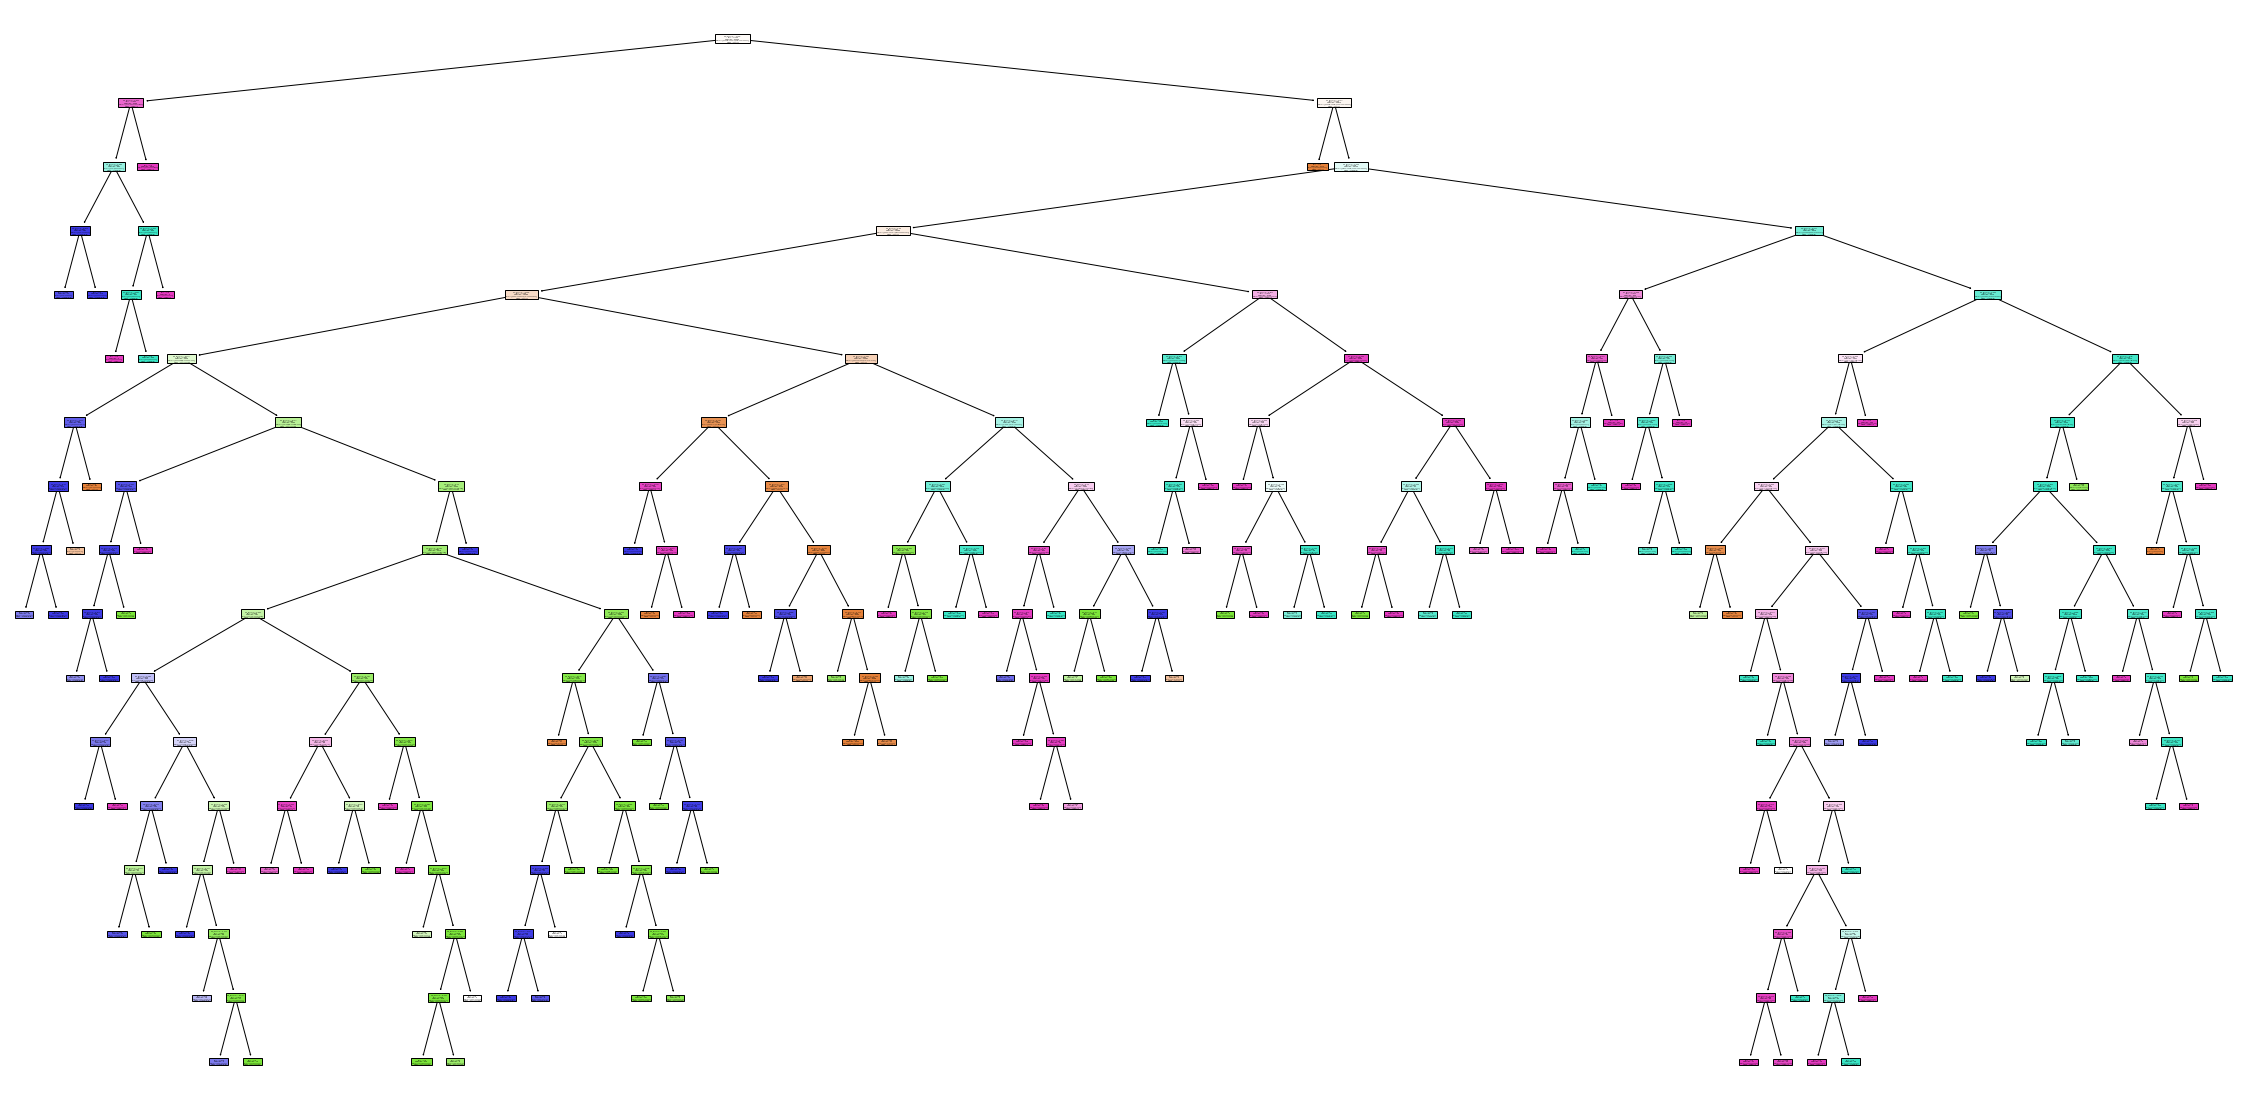

In [ ]:
plt.figure(figsize = (40,20))
_ = tree.plot_tree(reslt_tree['best model'], 
                   feature_names=['x1_mean', 'y1_mean', 'z1_mean', 'x2_mean', 'y2_mean', 'z2_mean', 'x3_mean','y3_mean', 'z3_mean', 'x4_mean', 'y4_mean', 'z4_mean'],  
                   class_names=['sitting', 'sittingdown', 'standing', 'standingup', 'walking'],
                   filled=True)

Сохраняем отбранные модели на диск

In [ ]:
from joblib import dump, load

In [ ]:
dump(reslt_tree['best model'], '/content/drive/MyDrive/models_for_har/tree.joblib')
dump(reslt_knn2['best model'], '/content/drive/MyDrive/models_for_har/knn2.joblib')
dump(reslt_knn1['best model'], '/content/drive/MyDrive/models_for_har/knn1.joblib')
dump(reslt_softmax['best model'], '/content/drive/MyDrive/models_for_har/softmax.joblib')

['/content/drive/MyDrive/models_for_har/softmax.joblib']

Протестируем нейронную сеть.

Интересующие гиперпараметры:
*   Число скрытых слоев и число нейронов в каждом
*   Коэффициент регуляризации L2
*   Размер батча
*   random state

Метод обучения везде один.
Функции активации ReLU до предпоследнего слоя, предпоследний слой - logistic.Последний - softmax- определен сразу.

In [ ]:
#словарь параметро в для решетчатого поиска (504 варианта )
ann_parameters =  [{'hidden_layer_sizes' : [(7),(8),(9)] ,
                  'alpha': [0.0001 , 0.001 , 0.01 ],
                  'batch_size' : [50 , 10 , 150 , 200 , 250 , 300 , 350],
                  'random_state' :[42,34, 56 ,78]},
                   {'hidden_layer_sizes' : [(10,7),(8,6),(10,8)] ,
                  'alpha': [0.0001 , 0.001 , 0.01 ],
                  'batch_size' : [50 , 10 , 150 , 200 , 250 , 300 , 350],
                  'random_state' :[42,34, 56 ,78]} ]


Создадим класс - нейронная сеть из базового класса модели sklearn

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from sklearn.base import BaseEstimator
from keras.utils import to_categorical
#from keras.callbacks import EarlyStopping

#, n_inputs , n_outputs , neurons_in_hiden,
 #                         activation , optimizer_type , metric , dropout_pr ,tol
class Keras_mlpclassifier( BaseEstimator  ):
    # constructor for network
    # loss - categorial cross entropy
    # activation on output layer - softmax
    
    def __init__(self, n_inputs , n_outputs , neurons_in_hiden, activation , optimizer_type , metrics , dropout_pr ,tol  ):
		   # n_inputs , n_outputs , neurons_in_hiden, activation , optimizer_type , metrics , dropout_pr ,tol  
       
       self.n_inputs = n_inputs  
       self.n_outputs = n_outputs
       self.neurons_in_hiden = neurons_in_hiden
       self.activation = activation
       self.optimizer_type = optimizer_type
        
       self.metrics = metrics
       self.dropout_pr = dropout_pr
       self.tol = tol
        
       self.ann = Sequential()

       N_layers = len(neurons_in_hiden) 
       self.ann.add(Dense(neurons_in_hiden[0] , input_dim= n_inputs  , activation = activation[0]) )
       self.ann.add(Dropout(dropout_pr))

       for i in range(1,N_layers):
           
          self.ann.add(Dense(neurons_in_hiden[i] , input_dim= n_inputs  , activation = activation[i]) )
          self.ann.add(Dropout(dropout_pr))

       self.ann.add(Dense(n_outputs ,  activation = 'softmax'))
 
       self.ann.compile(loss='categorical_crossentropy', optimizer=optimizer_type, metrics = metrics ) 
              
    
    def fit(self, X, Y, epochs, batch_size , verb):

      self.ann.fit( X,to_categorical(Y)  , epochs = epochs, batch_size = batch_size, verbose =verb )


      


    def predict_proba(self, X ):
        answers_prob = self.ann.predict(X)
        return answers_prob 

    def predict(self, X ):
        answers = np.argmax(self.predict_proba(X) , axis=1)
        return answers

Нормализуем даные.  И проверим количество элементов каждого класса в тренировочной выборке. 

In [ ]:
X_train_mn , X_val_mn , X_test_mn = scale_x(X_train, X_val, X_test, 'minmax')

In [ ]:
kolvo_unique = np.unique(Y_train,return_counts= True)[1]

Выборка сильно несбалансирована. Это затруднит обучение нейросети. Нужно сделать семплинг (увеличить число недостающих объектов). Один из способов - это простое копирование элементов малочисленного класса. Посмотрим, сколько элементов не хватает до ровного счета в каждом классе.

In [ ]:
kolvo_unique

array([10685,  2496,  9865,  2484,  8800])

In [ ]:
 delta = np.array([np.max(kolvo_unique) for i in range(5)]) - kolvo_unique

In [ ]:
  delta

array([   0, 8189,  820, 8201, 1885])

In [ ]:
 le.classes_

array(['sitting', 'sittingdown', 'standing', 'standingup', 'walking'],
      dtype=object)

Скопируем объекты классов 1 - 4 в отдельные массивы и увеличим их размеры до 10685

In [ ]:
X_1 = X_train_mn[Y_train == 1]
X_2 = X_train_mn[Y_train == 2]
X_3 = X_train_mn[Y_train == 3]
X_4 = X_train_mn[Y_train == 4]

In [ ]:
generator = np.random.seed(10000)

In [ ]:
kort_mass = [X_1, X_2 , X_3 ,X_4]
kort_mass_copies = [X_1, X_2 , X_3 ,X_4]
Y_tr_add = np.array([])
for i in range(4):
  lengthm = kort_mass[i].shape[0]
  nd_copy = (10685 // lengthm) -1
  nd_choise = 10685 % lengthm
  if nd_copy != 0 :
    for t in range(nd_copy):
      kort_mass_copies[i] = np.vstack(( kort_mass_copies[i] , kort_mass[i]  ))
  kort_mass_copies[i]  = np.vstack(( kort_mass_copies[i] ,  
                                      kort_mass[i][-nd_choise:]  ))  
  Y_tr_add = np.hstack((Y_tr_add , np.array([i+1 for t in range(10685) ] )  ) )
X_train2 = np.vstack(kort_mass_copies)

In [ ]:
X_train2 = np.vstack(( X_train_mn[Y_train == 0] , X_train2)) 
Y_tr_add = np.hstack(( Y_train[Y_train == 0] , Y_tr_add    ) )

In [ ]:
Y_tr_add.shape

(53425,)

In [ ]:
X_train2.shape


(53425, 12)

Теперь в тренировочной выборке 10685 элементов каждого класса
 

Теперь обучим нейросеть. Для валидации возмем 10 процентов обучающей выборки. Перед этим перемешаем данные

In [ ]:
from keras.optimizers import SGD 

In [ ]:
ann_models =[ Keras_mlpclassifier(12 , 5 , [9,7] , [ 'relu','sigmoid'] , SGD(learning_rate=0.01 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ) ,
              Keras_mlpclassifier(12 , 5 , [10,7] , [ 'relu','sigmoid'] , SGD(learning_rate=0.01 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ), 
             Keras_mlpclassifier(12 , 5 , [9,8] , [ 'relu','sigmoid'] , SGD(learning_rate=0.01 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,8] , [ 'relu','sigmoid'] , SGD(learning_rate=0.01 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,8,6] , [ 'relu','relu','sigmoid'] , SGD(learning_rate=0.01 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [9,8,6] , [ 'relu','relu','sigmoid'] , SGD(learning_rate=0.01 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,7,6] , [ 'relu','relu','sigmoid'] , SGD(learning_rate=0.01 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),

             Keras_mlpclassifier(12 , 5 , [9,7] , [ 'relu','sigmoid'] , SGD(learning_rate=0.125 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ) ,
              Keras_mlpclassifier(12 , 5 , [10,7] , [ 'relu','sigmoid'] , SGD(learning_rate=0.125 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ), 
             Keras_mlpclassifier(12 , 5 , [9,8] , [ 'relu','sigmoid'] , SGD(learning_rate=0.125 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,8] , [ 'relu','sigmoid'] , SGD(learning_rate=0.125 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,8,6] , [ 'relu','relu','sigmoid'] , SGD(learning_rate=0.125 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [9,8,6] , [ 'relu','relu','sigmoid'] , SGD(learning_rate=0.125 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,7,6] , [ 'relu','relu','sigmoid'] , SGD(learning_rate=0.125 ,momentum = 0.9 , nesterov = True) ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),

            Keras_mlpclassifier(12 , 5 , [9,7] , [ 'relu','sigmoid'] , 'Adam' ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ) ,
              Keras_mlpclassifier(12 , 5 , [10,7] , [ 'relu','sigmoid'] ,'Adam' ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ), 
             Keras_mlpclassifier(12 , 5 , [9,8] , [ 'relu','sigmoid'] , 'Adam' ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,8] , [ 'relu','sigmoid'] , 'Adam' ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,8,6] , [ 'relu','relu','sigmoid'] ,'Adam' ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [9,8,6] , [ 'relu','relu','sigmoid'] , 'Adam' ,[ 'CategoricalAccuracy'] , 0.4,0.00001 ),
             Keras_mlpclassifier(12 , 5 , [10,7,6] , [ 'relu','relu','sigmoid'] , 'Adam' ,[ 'CategoricalAccuracy'] , 0.4,0.00001 )]
             
             

In [ ]:
index_sh = np.arange(Y_tr_add.shape[0])
np.random.shuffle(index_sh  ) 

In [ ]:
Y_tr_add.shape

(53425,)

In [ ]:
 ann_models 

In [ ]:
list_of_f1_ann = np.zeros(21)
list_of_c_matr_ann = []

In [ ]:
X_train2.shape

(53425, 12)

In [ ]:
for i in range(21):
  print('train model ',i)
  print(ann_models[i])
  ann_models[i].fit(X_train2[index_sh ] , Y_tr_add[index_sh ]  , 1700 , 300 ,1 )
  print('estimation')
  Y_ann = ann_models[i].predict(X_val_mn)
  res_mod_i = conf_matr_and_score_f1(Y_ann ,Y_val , le)
  list_of_f1_ann[i] = res_mod_i['f1-score']
  list_of_c_matr_ann.append(res_mod_i['conf_matr'])

Выходные данные были обрезаны до нескольких последних строк (5000).
179/179 [==============================] - 1s 3ms/step - loss: 0.8781 - categorical_accuracy: 0.6244
Epoch 905/1700
179/179 [==============================] - 1s 3ms/step - loss: 0.8592 - categorical_accuracy: 0.6370
Epoch 906/1700
179/179 [==============================] - 1s 3ms/step - loss: 0.8638 - categorical_accuracy: 0.6329
Epoch 907/1700
179/179 [==============================] - 1s 3ms/step - loss: 0.8691 - categorical_accuracy: 0.6316
Epoch 908/1700
179/179 [==============================] - 1s 3ms/step - loss: 0.8746 - categorical_accuracy: 0.6320
Epoch 909/1700
179/179 [==============================] - 1s 3ms/step - loss: 0.8752 - categorical_accuracy: 0.6290
Epoch 910/1700
179/179 [==============================] - 1s 3ms/step - loss: 0.8629 - categorical_accuracy: 0.6313
Epoch 911/1700
179/179 [==============================] - 1s 3ms/step - loss: 0.8567 - categorical_accuracy: 0.6355
Epoch 912/1700
179/

Результаты оценки сетей на валидационном наборе

In [ ]:
list_of_f1_ann

array([0.95342538, 0.96775603, 0.89112199, 0.95761971, 0.6814051 ,
       0.4854072 , 0.07235232, 0.07270185, 0.25637889, 0.31125481,
       0.37661657, 0.07270185, 0.28731213, 0.31125481, 0.84760573,
       0.9742223 , 0.77717581, 0.98741699, 0.73060119, 0.94328906,
       0.91025865])

In [ ]:
np.argmax(list_of_f1_ann)+1

18

In [ ]:
np.max(list_of_f1_ann)

0.987416987067459

In [ ]:
list_of_c_matr_ann[np.argmax(list_of_f1_ann)]

,sitting,sittingdown,standing,standingup,walking
sitting,3554,0,0,8,0
sittingdown,1,825,1,5,0
standing,0,6,3268,8,6
standingup,0,10,0,818,0
walking,0,2,97,0,2835


In [ ]:
ann_models[np.argmax(list_of_f1_ann)]

Keras_mlpclassifier(activation=['relu', 'sigmoid'], dropout_pr=0.4,
                    metrics=['CategoricalAccuracy'], n_inputs=12, n_outputs=5,
                    neurons_in_hiden=[10, 8], optimizer_type='Adam', tol=1e-05)

Лучшая сеть - это 12 10 8 5 с оптимизатором Adam

In [ ]:
ann_12_10_8_5_Adam = ann_models[np.argmax(list_of_f1_ann)]

Оценим её на тестовом наборе

In [ ]:
Y_ann = ann_12_10_8_5_Adam.predict(X_test_mn)

In [ ]:
 
result_of_ann_test  = conf_matr_and_score_f1(Y_ann,Y_test , le)

In [ ]:
result_of_ann_test['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3559,0,0,3,0
sittingdown,4,819,1,8,0
standing,0,6,3270,7,6
standingup,0,12,0,816,0
walking,0,5,101,0,2827


In [ ]:
result_of_ann_test['f1-score']

0.9866305487591751

Оценим результаты моделей на тестовом наборе.
Загружаем созхраненные модели

In [ ]:
from joblib import dump, load

In [ ]:
tree = load( '/content/drive/MyDrive/models_for_har/tree.joblib')
knn2 = load( '/content/drive/MyDrive/models_for_har/knn2.joblib')
knn1 = load( '/content/drive/MyDrive/models_for_har/knn1.joblib')
softmax  = load( '/content/drive/MyDrive/models_for_har/softmax.joblib')

Вырабатываем прогнозы

In [ ]:
result_of_knn1_test  = conf_matr_and_score_f1(knn1.predict(X_test_mn) ,Y_test , le)
result_of_knn2_test  = conf_matr_and_score_f1(knn2.predict(X_test_mn) ,Y_test , le)
result_of_tree_test  = conf_matr_and_score_f1(tree.predict(X_test_std) ,Y_test , le)
result_of_softmax_test  = conf_matr_and_score_f1(softmax.predict(X_test_std) ,Y_test , le)

Результат метода ближайших соседей без взвешенной метрики

In [ ]:
result_of_knn1_test['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,0,830,2,0,0
standing,0,0,3289,0,0
standingup,0,0,0,828,0
walking,0,0,0,0,2933


In [ ]:
result_of_knn1_test['f1-score']

0.9998252359314925

Результат метода ближайших соседей со взвешенной метрикой

In [ ]:
result_of_knn2_test['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,0,831,1,0,0
standing,0,0,3289,0,0
standingup,0,0,0,828,0
walking,0,0,0,0,2933


In [ ]:
result_of_knn2_test['f1-score']

0.9999126179657463

Результат метода  без взвешенной метрики

In [ ]:
result_of_tree_test['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3558,3,0,0,1
sittingdown,5,814,1,7,5
standing,0,0,3287,1,1
standingup,1,1,7,819,0
walking,0,3,6,2,2922


In [ ]:
result_of_tree_test['f1-score']

0.9961551904928346

In [ ]:
result_of_softmax_test['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3561,0,0,1,0
sittingdown,3,827,2,0,0
standing,0,0,3282,0,7
standingup,0,4,0,823,1
walking,0,2,13,0,2918


In [ ]:
result_of_softmax_test['f1-score']

0.9971163928696261

Оценим нейросеть на тестовом наборе

In [ ]:
Y_ann = ann_12_10_8_5_Adam.predict(X_test_mn)

In [ ]:
 
result_of_ann_test  = conf_matr_and_score_f1(Y_ann,Y_test , le)

In [ ]:
result_of_ann_test['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3559,0,0,3,0
sittingdown,4,819,1,8,0
standing,0,6,3270,7,6
standingup,0,12,0,816,0
walking,0,5,101,0,2827


In [ ]:
result_of_ann_test['f1-score']

0.9866305487591751

Нейросеть в данном случае показала худший результат

Протестируем ансамбли

Беггинг.
Попробуем на разных классификаторах 
*   SoftMax
*   K ближайших соседей
*   Решающее дерево (Случайый лес)
*   Нейронная сеть

Варианты количества базовых моделей 2, 3, 4


In [ ]:
from sklearn.ensemble import BaggingClassifier , GradientBoostingClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from  sklearn.neighbors import KNeighborsClassifier

In [ ]:
base_models_list =[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=20, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=30,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=167, splitter='random') ,
                   LogisticRegression(C=14.75, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='multinomial', n_jobs=None, penalty='l2',
                    random_state=None, solver='newton-cg', tol=0.0001, verbose=2,
                    warm_start=False) 
                    
                   ]

In [ ]:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                      weights='distance') , 
                   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='wminkowski',
                      metric_params={'w': np.array([1.82, 2.89, 2.47, 2.07, 0.96, 2.01, 1.63, 2.53, 2.94, 1.62, 1.29, 1.75])},
                      n_jobs=None, n_neighbors=2, p=2, weights='distance')

In [ ]:
bag_params = {'base_estimator' : base_models_list,
              'n_estimators': [2,3,4,5],
              'max_samples' : [0.6 , 0.65 , 0.7 , 0.75 , 0.8 , 0.85 ],
              'max_features' : [0.65 , 0.6   , 0.75 , 0.8],
              'oob_score' : [True ,False],
              'random_state' : [25,34,41,56,78]}

In [ ]:
reslt_bagging = fit_and_choose(X_train_std ,Y_train , 
                        BaggingClassifier(  bootstrap = True ,bootstrap_features = True ,verbose=2) , 
                       bag_params,
                       'f1_micro' , 
                        StratifiedKFold(n_splits=3,  shuffle=True, random_state = 42 ), 4,-1  )

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 754 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1734 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2372 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2998 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 3415 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 3880 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done 4395 tasks      | elapsed: 103.0min
[Parallel(n_jobs=-1)]: Done 4958 tasks      | elapsed: 146.1min
[Parallel(n_jobs=-1)]: Done 5571 tasks      | elapsed: 193.2min


Building estimator 1 of 5 for this parallel run (total 5)...
Building estimator 2 of 5 for this parallel run (total 5)...
Building estimator 3 of 5 for this parallel run (total 5)...
Building estimator 4 of 5 for this parallel run (total 5)...
Building estimator 5 of 5 for this parallel run (total 5)...


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 209.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


In [ ]:
reslt_bagging 

{'best model': BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=30,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                  

Проверим модель на валидационном наборе

In [ ]:
result_of_bag_tree_softmax_val  = conf_matr_and_score_f1(reslt_bagging['best model'].predict(X_val_std) ,Y_val , le)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [ ]:
result_of_bag_tree_softmax_val['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,1,829,1,1,0
standing,0,0,3287,0,1
standingup,1,3,0,824,0
walking,0,0,4,0,2930


In [ ]:
result_of_bag_tree_softmax_val['f1-score']

0.998951415588955

Сохраним найденную модель

In [ ]:
from joblib import dump, load
dump(reslt_bagging['best model'], '/content/drive/MyDrive/models_for_har/bagging_tree_and_softmax.joblib')

['/content/drive/MyDrive/models_for_har/bagging_tree_and_softmax.joblib']

Теперь, когда лушие параметры найдены попробуем улучшить оценку на валидационном наборе путем увеличение количества моделей.

In [ ]:
bag_params2 = { 'n_estimators': [6 , 7 ,8 , 10 , 11 ,12, 13 ,14 , 15 , 16] }

In [ ]:
bag_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=30,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                         random_state=167,
                                                         splitter='random'),
                   bootstrap=True, bootstrap_features=True, max_features=0.75,
                   max_samples=0.8,  n_jobs=-1, oob_score=True,
                   random_state=34, verbose=2, warm_start=False)

In [ ]:
reslt_bagging2 = fit_and_choose(X_train_std ,Y_train , 
                        bag_model , 
                       bag_params2,
                       'f1_micro' , 
                        StratifiedKFold(n_splits=3,  shuffle=True, random_state = 42 ), 4,-1  )

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 14 for this parallel run (total 14)...
Building estimator 2 of 14 for this parallel run (total 14)...
Building estimator 3 of 14 for this parallel run (total 14)...
Building estimator 4 of 14 for this parallel run (total 14)...
Building estimator 5 of 14 for this parallel run (total 14)...
Building estimator 6 of 14 for this parallel run (total 14)...
Building estimator 7 of 14 for this parallel run (total 14)...
Building estimator 8 of 14 for this parallel run (total 14)...
Building estimator 9 of 14 for this parallel run (total 14)...
Building estimator 10 of 14 for this parallel run (total 14)...
Building estimator 11 of 14 for this parallel run (total 14)...
Building estimator 12 of 14 for this parallel run (total 14)...
Building estimator 13 of 14 for this parallel run (total 14)...
Building estimator 14 of 14 for this parallel run (total 14)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


In [ ]:
reslt_bagging2

{'best model': BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=30,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                  

Проверяем модель на валидационой выборке.

In [ ]:
result_of_bag_tree_softmax_val2  = conf_matr_and_score_f1(reslt_bagging2['best model'].predict(X_val_std) ,Y_val , le)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [ ]:
result_of_bag_tree_softmax_val2['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,0,830,0,2,0
standing,0,0,3288,0,0
standingup,0,0,0,828,0
walking,0,0,0,0,2934


In [ ]:
result_of_bag_tree_softmax_val2['f1-score']

0.9998252359314925

In [ ]:
dump(reslt_bagging2['best model'], '/content/drive/MyDrive/models_for_har/bagging_tree_and_softmax2.joblib')

['/content/drive/MyDrive/models_for_har/bagging_tree_and_softmax2.joblib']

In [ ]:
Оценим работу моделей на тестовой выборке

In [ ]:
bagging_tree_and_softmax = load( '/content/drive/MyDrive/models_for_har/bagging_tree_and_softmax.joblib')
bagging_tree_and_softmax2 = load( '/content/drive/MyDrive/models_for_har/bagging_tree_and_softmax2.joblib')

In [ ]:
result_of_bag_tree_softmax_test  = conf_matr_and_score_f1(bagging_tree_and_softmax.predict(X_test_std) ,Y_test , le)
result_of_bag_tree_softmax_test2  = conf_matr_and_score_f1(bagging_tree_and_softmax2.predict(X_test_std) ,Y_test , le)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Беггинг с 5 моделями

In [ ]:
result_of_bag_tree_softmax_test['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,2,825,2,3,0
standing,0,0,3287,0,2
standingup,1,1,0,826,0
walking,0,0,1,0,2932


In [ ]:
result_of_bag_tree_softmax_test['f1-score']

0.998951415588955

Беггинг с 14 моделями

In [ ]:
result_of_bag_tree_softmax_test2['conf_matr']

,sitting,sittingdown,standing,standingup,walking
sitting,3562,0,0,0,0
sittingdown,1,826,2,1,2
standing,0,0,3289,0,0
standingup,0,0,0,828,0
walking,0,0,2,0,2931


In [ ]:
result_of_bag_tree_softmax_test2['f1-score']

0.9993009437259699

На тестовой выборке лучше показал себя беггинг с 14 деревьями.
Но он уступает методу ближайших соседей со взвешенной метрикой - его оценка
f1 - 0.999912 и всего 1 неправильно классифицированный объект